In [337]:
import pandas as pd
from matplotlib import pyplot as plt
import re
from data_cleaning import *
from matplotlib import pyplot as plt

# pd.set_option('display.max_colwidth', -1) # displace all text within a col 

In [220]:
df = pd.read_csv('all.csv').drop('Unnamed: 0', axis=1).drop_duplicates('alltext')

In [221]:
df.groupby('category')['id'].count()

category
Dress    4394
Top      5632
Name: id, dtype: int64

In [222]:
df.groupby('website')['id'].count()

website
ASOS             6896
Bloomingdales     958
Fashion Nova      395
HM                697
Macy             1080
Name: id, dtype: int64

In [223]:
import re
df=df.dropna(subset=['price'])
df.price = df.price.map(lambda x: float(re.sub('[$,]','', x)))
df.shape

(10015, 12)

# avg price per website

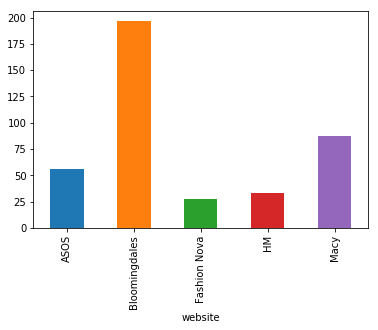

In [224]:
df.groupby(['website'])['price'].mean().plot.bar()

# data pre-processing

simple_preprocess() in word2vec will convert a document into a list of lowercase tokens, punctuation and numbers will be removed. However, futher pre-processing is needed before NLP

1) replace t-shirt/T-shirt with tshirt/Tshirt to be counted as one token

2) materials: 
convert (Viscose 100%) to (Viscose100%, Viscose)
convert (100% Viscose) to (Viscose100%, Viscose)

3) remove brands: 
PrettyLittleThing, ASOS DESIGN, 'ASOS', "YAS", "Ditsy", "Noisy", "May", "Ted","Baker", "River","Island", "Karen","Scott", "PrettyLittleThing", "Roxy", "DESIGN", "Chi", "Alfani", "Boohoo", "Sofie", "Schnoor", "Ellesse", "Jeannie", "TFNC", "Sacred", "Hawk", "Urban", "Bliss", "Puma", "adidas", "Stella"

4) remove words: 
cm
size,
‘Web ID:’ 
Approx. model height is 5'10" and she is wearing a size 4/S
Made In USA Made In USA


In [225]:
df = data_cleaning(df) # from data_cleaning

In [226]:
df.iloc[1128,0]

' a relaxed fit  cropped silhouette update th calvin klein performance tshirt  in soft fabric with a bold logo for a stylh addition to your active or casual look  hits at   relaxed fit inspired for  athleure round neckline  long sleeves with drop shoulders cotton modal spex mane washable impor       '

In [316]:
df.sample(5)


,alltext,brand,category,description,img_2,img_id,img_url,material,price,product_name,website,id
8686,maternity nursing tiered double layer plea s...,NaN,Dress,"Tiered color-block design,The bolder, the bett...",NaN,NaN,https://images.asos-media.com/products/asos-de...,"Lightweight fabric ,Floaty, floaty,Main: 100% ...",51.00,ASOS DESIGN maternity nursing tiered double la...,ASOS,8686
82,silkblend jersey top premium quality shortsle...,HM,Top,PREMIUM QUALITY. Short-sleeved top in soft jer...,NaN,82 Silk-blend Jersey Top,https://lp2.hm.com/hmgoepprod?set=source[/cd/9...,Back: Length: 63.5 cm (Size M),34.99,Silk-blend Jersey Top,HM,82
4407,superdry racer back tank scoop neck crochet st...,NaN,Top,"Scoop neck,Crochet straps,It's all in the deta...",NaN,NaN,https://images.asos-media.com/products/superdr...,"Soft-touch jersey,You can count on me ,Body: 5...",32.00,Superdry Racer Back Tank,ASOS,4407
6771,jaded london festival kimono in carnival print...,NaN,Top,"Not just for festivals,All-over print,For patt...",NaN,NaN,https://images.asos-media.com/products/jaded-l...,"Lightweight woven fabric,Drapes softly over th...",79.00,Jaded London Festival Kimono In Carnival Print,ASOS,6771
8987,john zack tall plunge front ruffle tea dress i...,NaN,Dress,"Not just for tea time,Plunge neck,Long sleeves...",NaN,NaN,https://images.asos-media.com/products/john-za...,"Lightweight woven fabric,The kind that doesn't...",79.00,John Zack Tall plunge front ruffle tea dress i...,ASOS,8987


note: no need to hold out the test data, as data is unlabelled (NLP is unsupervised learning)

# NLP Analysis

### word2vec

In [69]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

class MySentences(object): 
    def __iter__(self):
        for i in range(df.shape[0]):
            yield simple_preprocess(df.iloc[i,0]) # generator  


In [60]:
assert gensim.models.doc2vec.FAST_VERSION > -1, "this will be painfully slow otherwise"

In [62]:
%%time
import multiprocessing
import os
cores = multiprocessing.cpu_count()

if not os.path.exists('models/word2vec.model'):
    print("start traing word2vec model...")
    sentences = MySentences() # a memory-friendly iterator
    #10 hidden layers, look up -5/+5 window. Drop out words show up less than 2 times
    word2vec_model = gensim.models.Word2Vec(sentences, size=10, window=5, min_count=2, workers=cores)  
    
    #epoch larger to ensure it converge
    word2vec_model.train(sentences, total_examples = word2vec_model.corpus_count, epochs=10)
                
    if not os.path.exists('models'):                                                          
        os.makedirs('models')
        word2vec_model.save('models/word2vec.model')
    else:
        word2vec_model.save('models/word2vec.model')
else:
    word2vec_model = Word2Vec.load('models/word2vec.model')

start traing word2vec model...
CPU times: user 23 s, sys: 263 ms, total: 23.3 s
Wall time: 17.7 s


## Method 1: pretrained model for word2vec

#### use pretrained model because our sample size is too small (only around 50k words) compare to pretrained models with 100k or 1M words

In [63]:
from pretrain_model import *
from IPython.display import Image

In [65]:
pretrain_model = loadGloveModel('glove.42B.300d.txt')

Loading Glove Model
Done. 1917494  words loaded!


In [96]:
print( find_similar(df, 100, pretrain_model, count = 20))
pretrain_similar = find_similar(df, 100, pretrain_model, count = 20)

[(100, 1.0), (204, 0.960734265828717), (127, 0.9532909762977771), (206, 0.9518106946985845), (129, 0.9515571908715034), (74, 0.9505915234467651), (253, 0.9501979595726253), (113, 0.9492253970828751), (257, 0.9492253970828751), (231, 0.9476012341353779), (34, 0.9456792049094209), (67, 0.9422398250427261), (221, 0.9420453052039244), (188, 0.9405505509835118), (538, 0.9393099703403387), (170, 0.9385514286183384), (35, 0.9385514286183383), (9771, 0.937779079079627), (161, 0.9373998739795714), (200, 0.9372290849067381)]


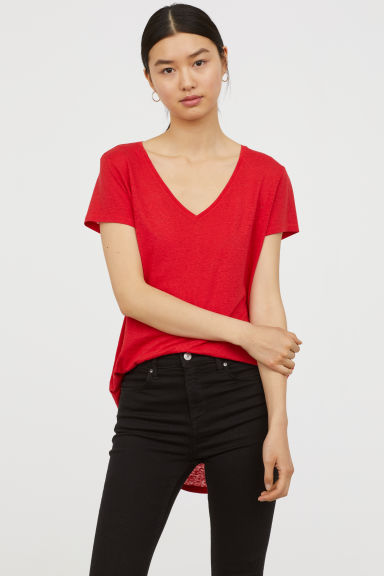

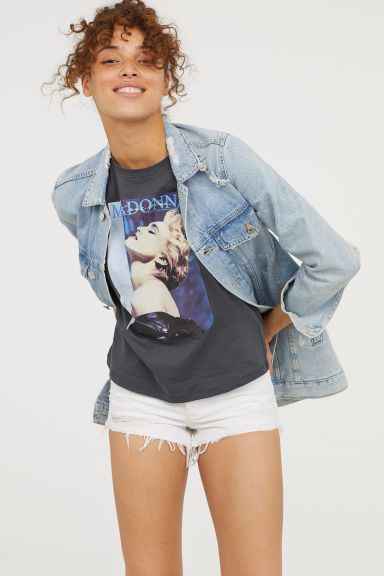

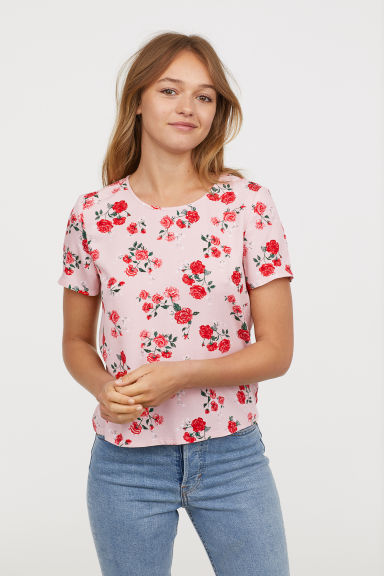

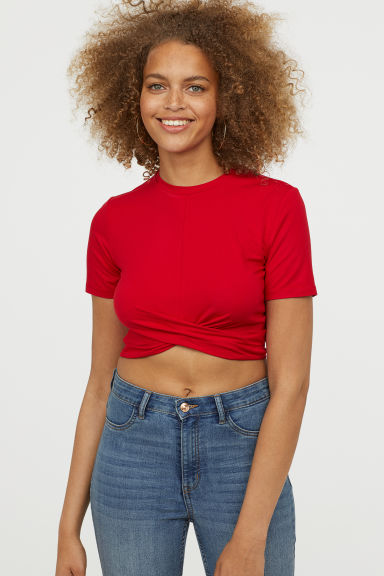

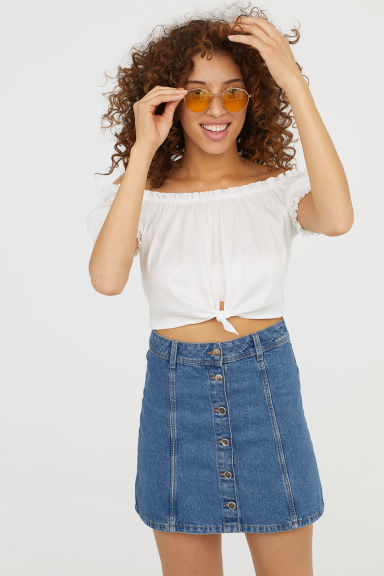

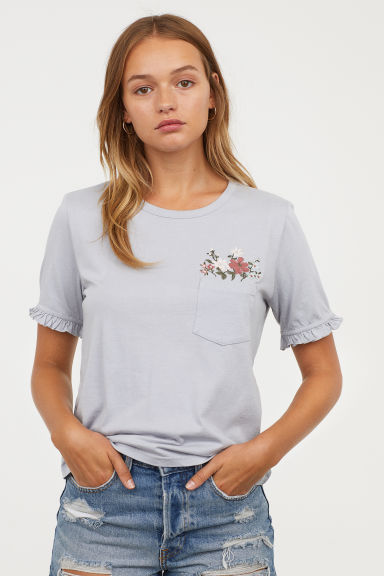

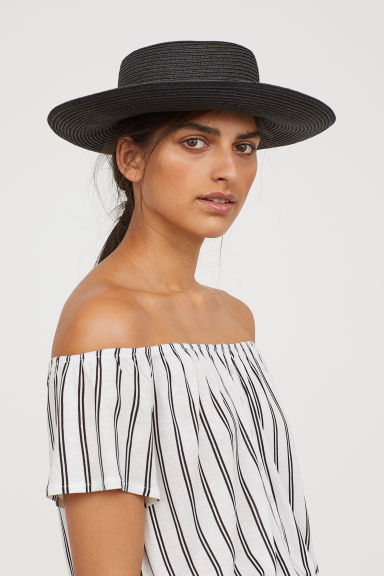

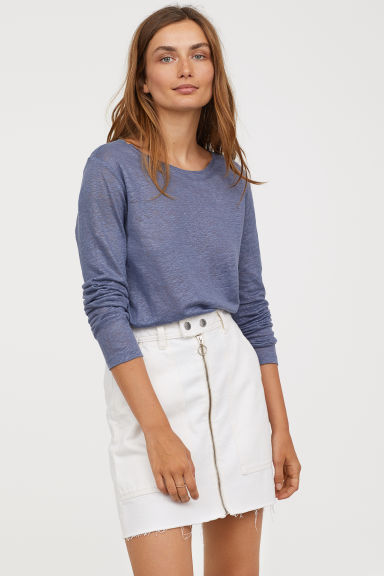

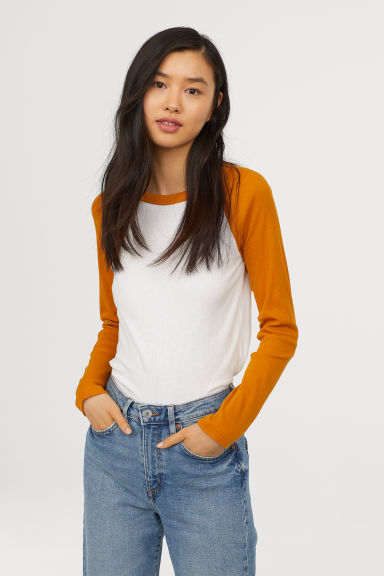

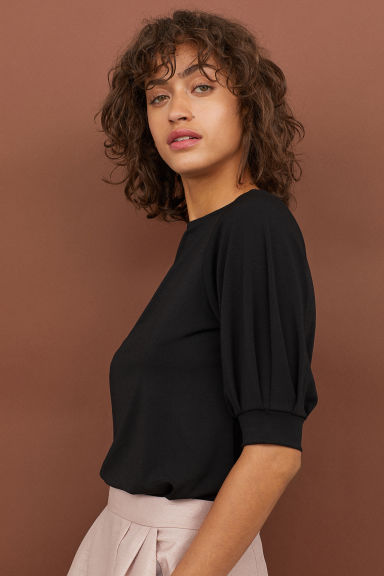

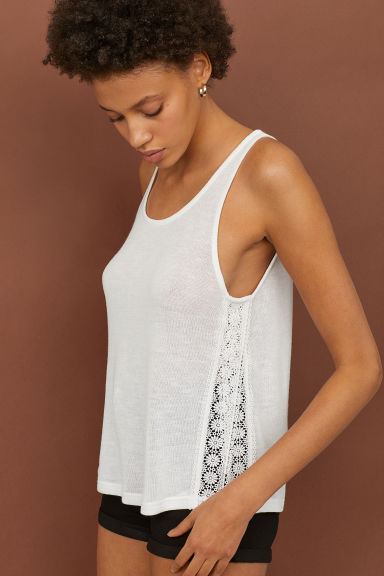

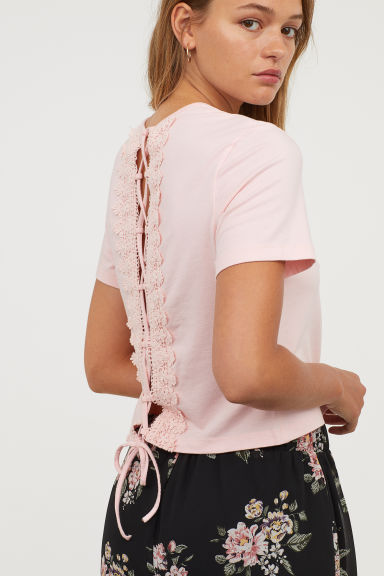

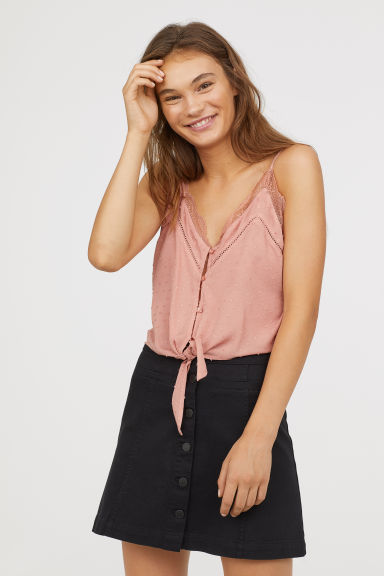

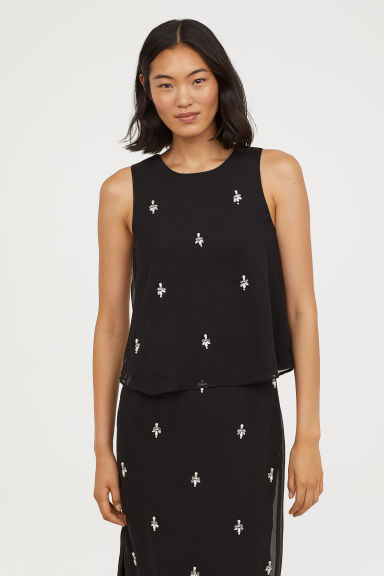

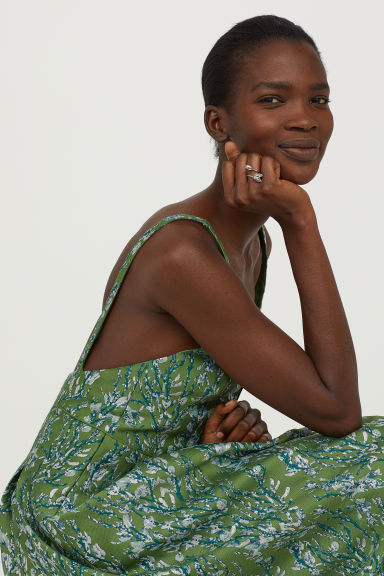

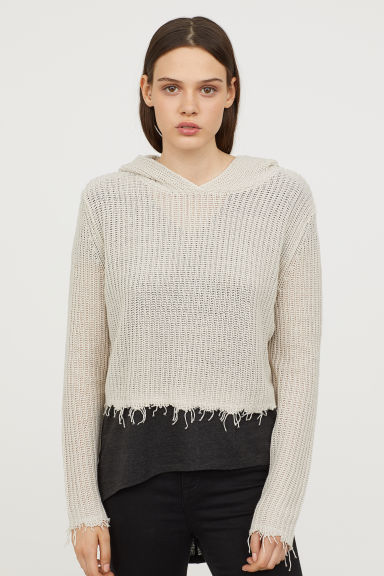

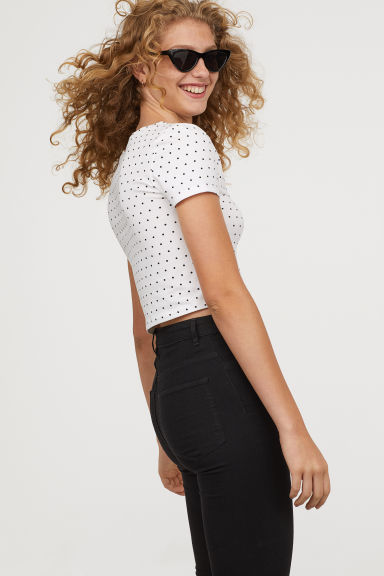

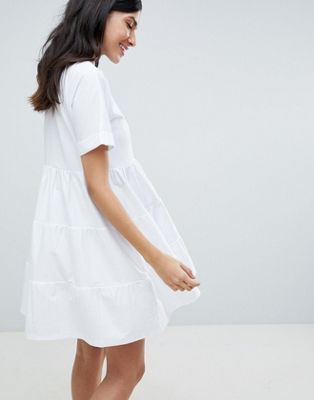

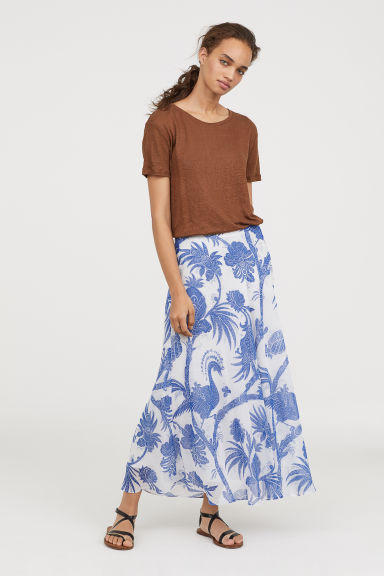

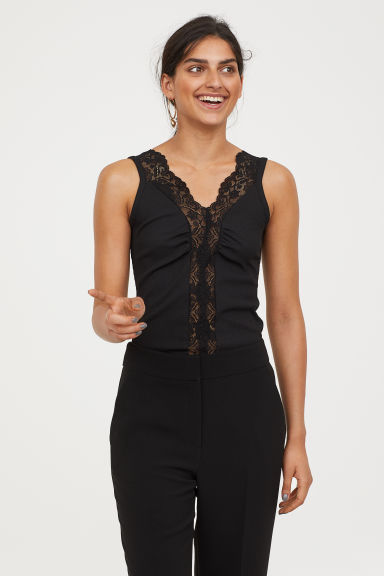

In [98]:
for i in range(len(pretrain_similar)):
    display(Image(filename = './product_images/'+str(pretrain_similar[i][0])+'.jpg', width=200, height=200))

## Method 2: tfidf 

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

In [354]:
tfidf_vectorizer = TfidfVectorizer(
    analyzer="word", tokenizer=simple_preprocess,   # tokenizer = nltk.word_tokenize
    preprocessor=None, stop_words='english', max_features=None)     


features = tfidf.fit_transform(df.alltext)
tfidf_list = list(map(list, (zip(tfidf.get_feature_names(), tfidf.idf_))))

In [355]:
for i in range(len(tfidf_list)): 
    tfidf_list[i][1] =  1/ tfidf_list[i][1]  # make more common words have larger weight

In [356]:
tfidf_list = sorted(tfidf_list, key =lambda x: x[1], reverse = True)  # sorted from most common to least common words
tfidf_list  

[['fit', 0.6641807474084849],
 ['polyester', 0.627710040728446],
 ['the', 0.6269271824614803],
 ['neck', 0.6175632108913555],
 ['in', 0.5941717765136499],
 ['with', 0.5738299890473423],
 ['to', 0.5661050010399117],
 ['regular', 0.5584731971379382],
 ['you', 0.5500416573788085],
 ['dress', 0.5369939838411777],
 ['fabric', 0.5283431939412329],
 ['main', 0.5277307698647722],
 ['for', 0.5054497712853078],
 ['cut', 0.490250236368261],
 ['cotton', 0.4750316129564341],
 ['spex', 0.46931317971364406],
 ['sleeves', 0.4650184680652905],
 ['fits', 0.45627335749436654],
 ['body', 0.4532601704998643],
 ['just', 0.44694610125150186],
 ['that', 0.43777967735083667],
 ['right', 0.4357048628293543],
 ['it', 0.4305742241655432],
 ['back', 0.4288365305910112],
 ['jersey', 0.41807748588659804],
 ['front', 0.40933562780575544],
 ['woven', 0.40415098456987886],
 ['top', 0.40329575370034837],
 ['true', 0.3969965866495376],
 ['your', 0.3921658541949286],
 ['of', 0.38839405475612365],
 ['th', 0.381815093174300

In [159]:
tfidf_dict = dict(tfidf_list)

In [175]:
from tfidf import *
find_similar(df, 100, tfidf_dict, count = 10)
    

TypeError: unsupported operand type(s) for *: 'NoneType' and 'NoneType'

## method 3: doc2vec

In [68]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [69]:
# MyDocs reading from a data frame
class MyDocs(object):
    def __iter__(self):
        for i in range(df.shape[0]):
            yield TaggedDocument(words=simple_preprocess(df.iloc[i,0]), tags=['%s' % df.iloc[i,-1]])  
            # TaggedDocument classify reviews

In [105]:
%%time

if not os.path.exists('models/doc2vec.model'):
    print("start traing doc2vec model...")
    documents = MyDocs()                                                                 # workers=cores means number of CPUs
    doc2vec_model = Doc2Vec(dm=0, dbow_words=1, vector_size=200, window=3, min_count=2, workers=cores) # dm=1, dbow_words=1 means train two models and take the average
    doc2vec_model.build_vocab(documents)
    doc2vec_model.train(documents, total_examples=doc2vec_model.corpus_count, epochs=100) 
    if not os.path.exists('models'):
        os.makedirs('models')
        doc2vec_model.save('models/doc2vec.model')
    else:
        doc2vec_model.save('models/doc2vec.model')
else:
    doc2vec_model = Doc2Vec.load('models/doc2vec.model')
    
    # no pretrained model for doc to vec because each document is unique per training set. word to vec can be generalized

start traing doc2vec model...
CPU times: user 7min 26s, sys: 22.2 s, total: 7min 48s
Wall time: 4min 7s


In [108]:
def load_img_d2v(model, item, n):
    doc2vec_model = Doc2Vec.load(model)
    print(doc2vec_model.docvecs.most_similar(item, topn=n))
    d2v_similar = doc2vec_model.docvecs.most_similar(item, topn=n)

    # show img
    display(Image(filename = './product_images/'+item+'.jpg', width=200, height=200))
    for i in range(len(d2v_similar)):
        display(Image(filename = './product_images/'+str(d2v_similar[i][0])+'.jpg', width=200, height=200))

[('1', 0.6814905405044556), ('330', 0.6718116998672485), ('336', 0.664460301399231), ('20', 0.6572907567024231), ('4669', 0.6533445119857788), ('31', 0.6359493732452393), ('6511', 0.6346524357795715), ('572', 0.621757447719574), ('41', 0.6154969334602356), ('7346', 0.6151467561721802), ('5059', 0.6096570491790771), ('190', 0.6023114919662476), ('5290', 0.6019721627235413), ('8212', 0.597015380859375), ('5380', 0.5959575176239014), ('37', 0.5954045057296753), ('3589', 0.5934072732925415), ('9857', 0.5932191610336304), ('545', 0.5928370952606201), ('6333', 0.5899505019187927)]


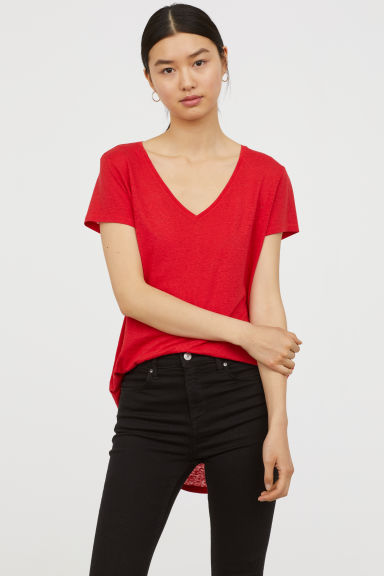

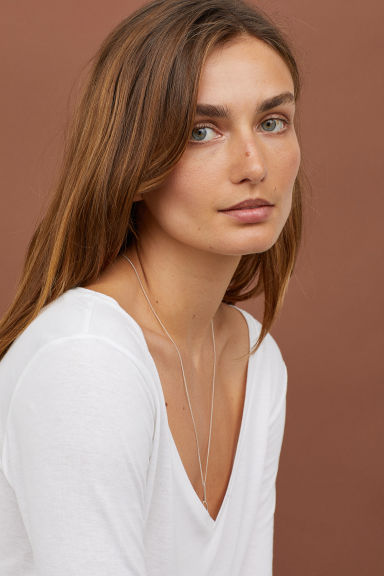

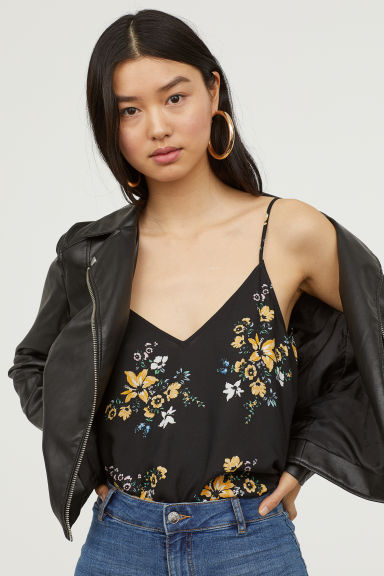

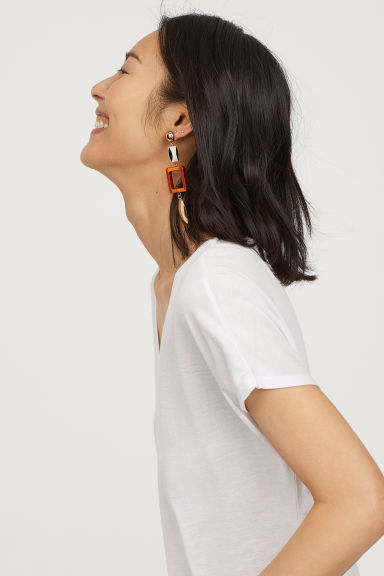

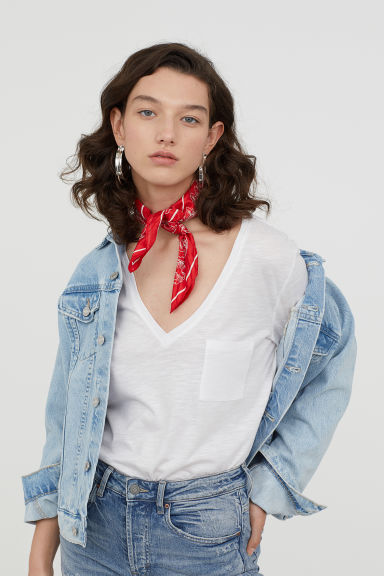

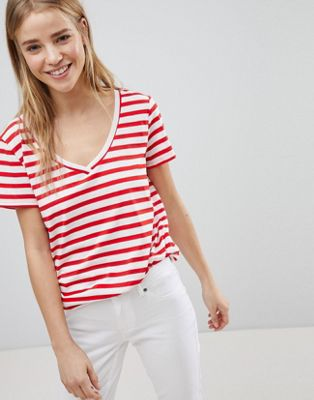

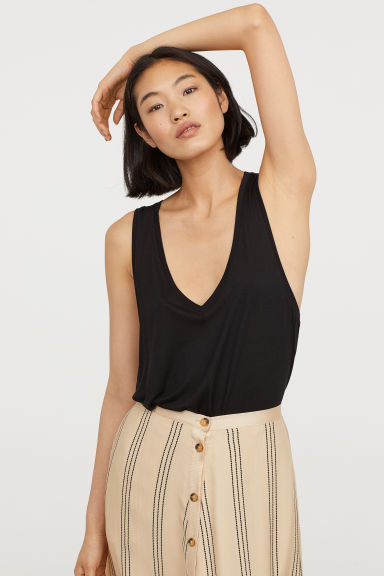

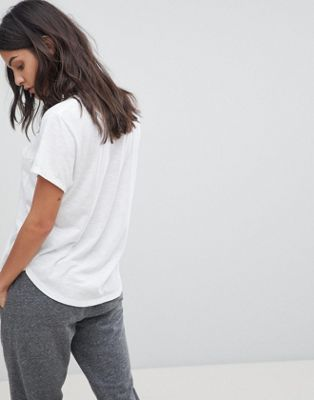

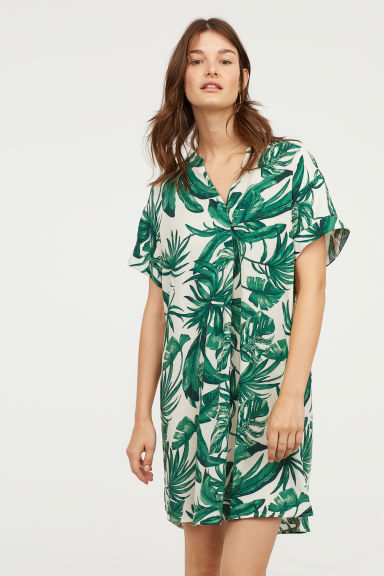

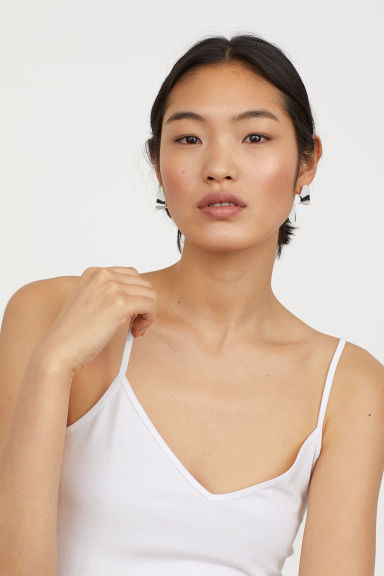

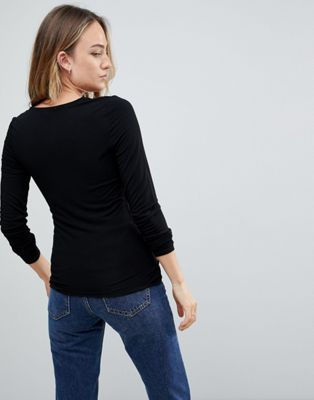

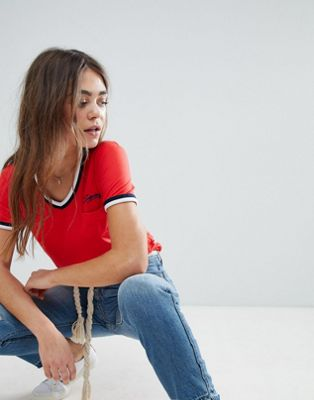

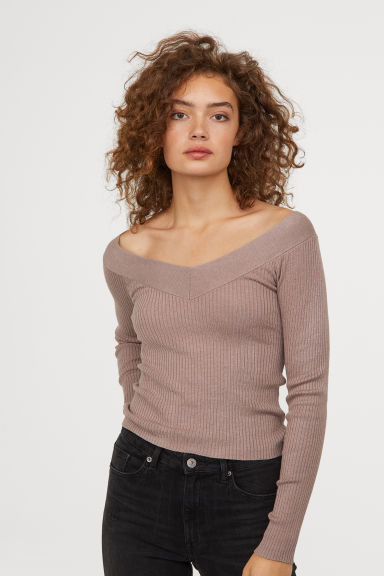

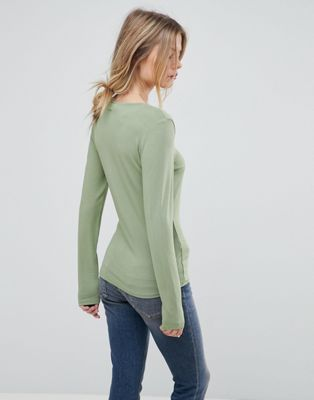

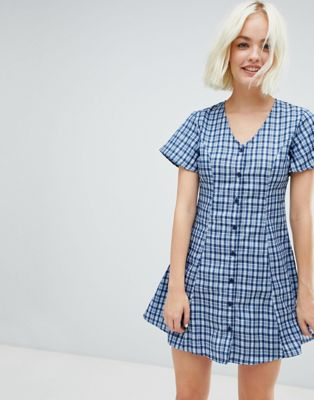

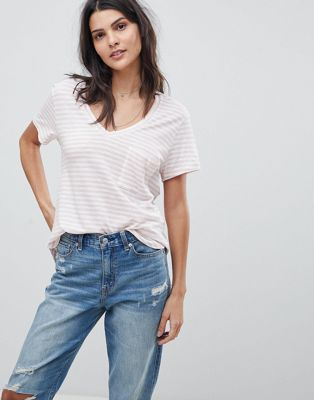

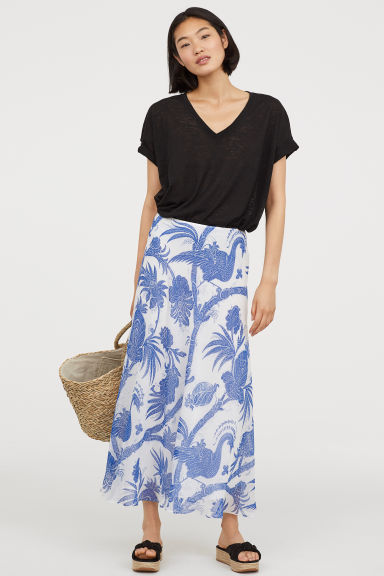

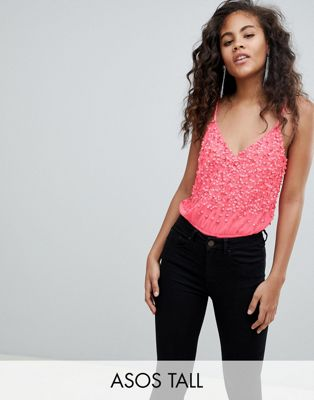

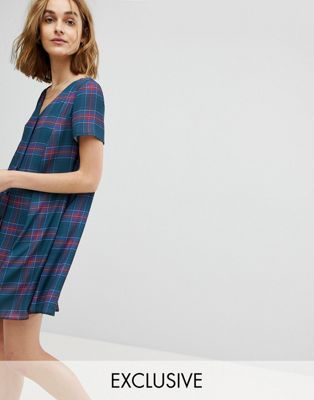

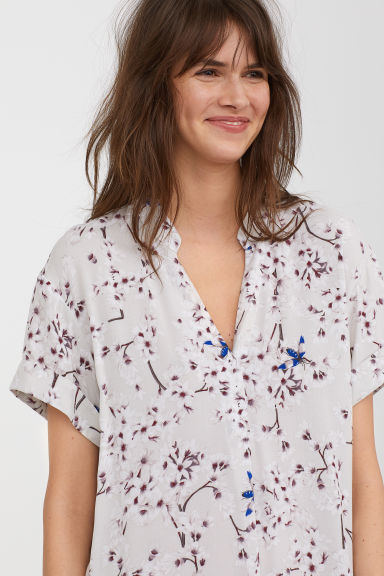

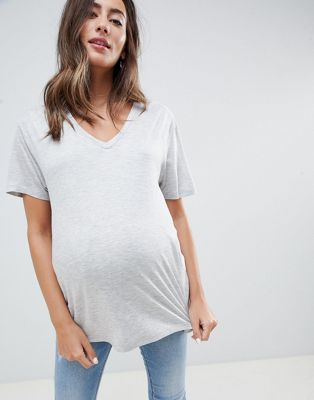

In [113]:
# dm = 1, dbow_words=1

load_img_d2v('models/doc2vec_dm1_word1_vec200_win3_min2_epoch100.model', '100', 20)    

[('336', 0.7351894378662109), ('20', 0.7306736707687378), ('1', 0.7166502475738525), ('31', 0.6706709861755371), ('572', 0.6669712066650391), ('41', 0.6623464822769165), ('4669', 0.652741551399231), ('37', 0.6434482932090759), ('330', 0.6420900821685791), ('5380', 0.6354026794433594), ('8212', 0.6344871520996094), ('220', 0.6320120096206665), ('7346', 0.6317950487136841), ('5290', 0.6313682794570923), ('9857', 0.6305119395256042), ('6511', 0.626423180103302), ('9357', 0.6145697236061096), ('3589', 0.6110650897026062), ('908', 0.6074733734130859), ('51', 0.6051846742630005)]


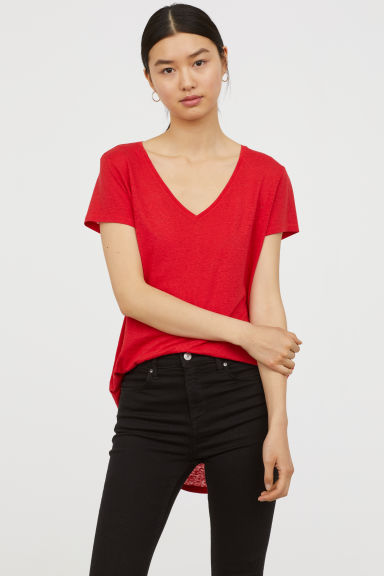

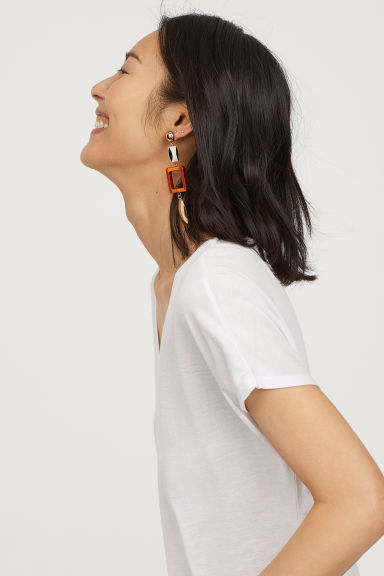

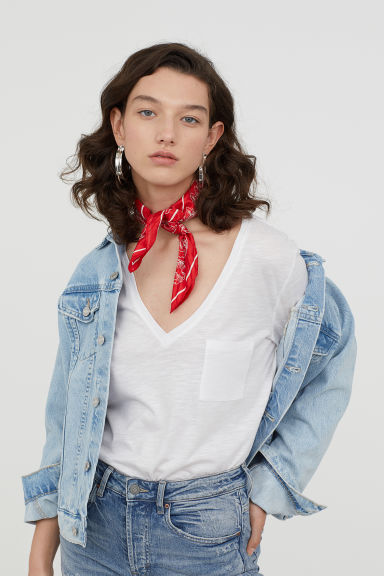

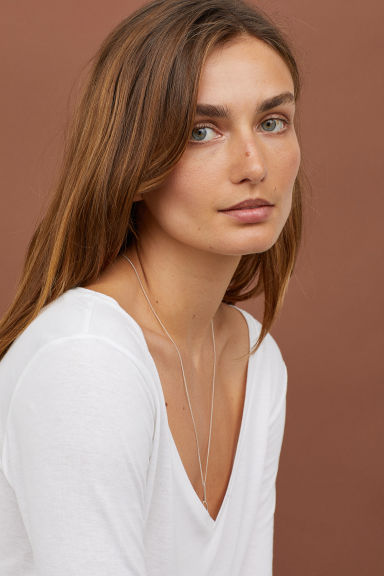

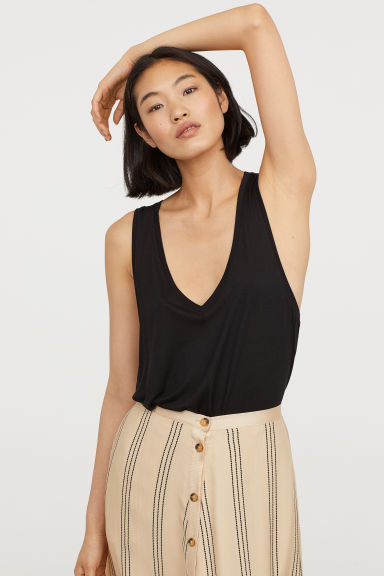

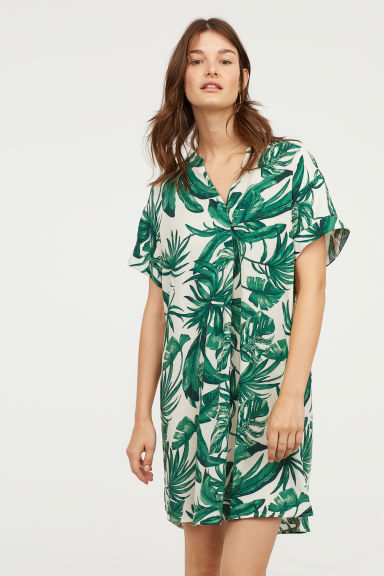

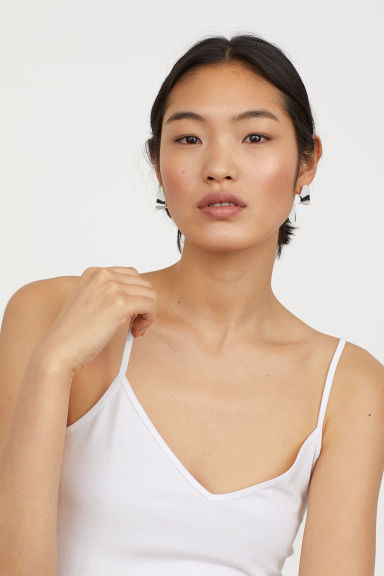

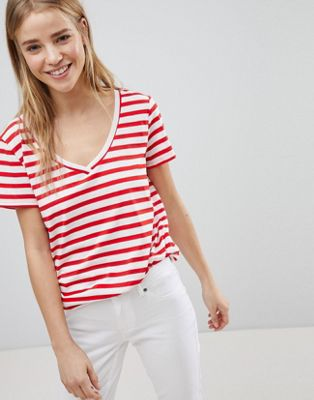

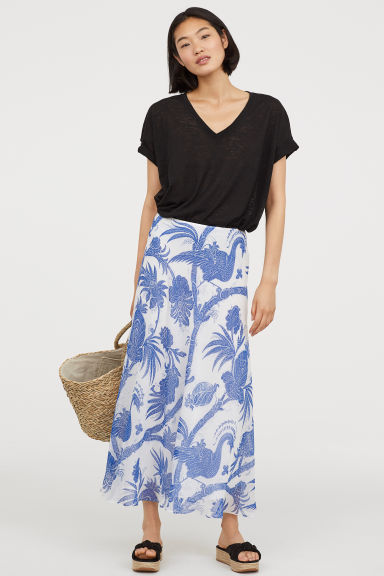

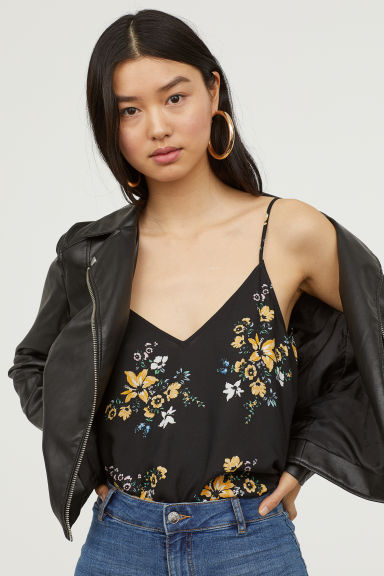

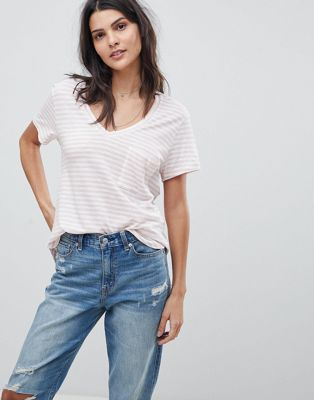

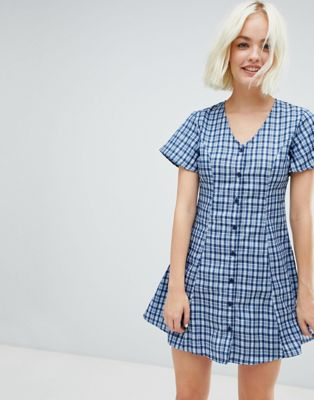

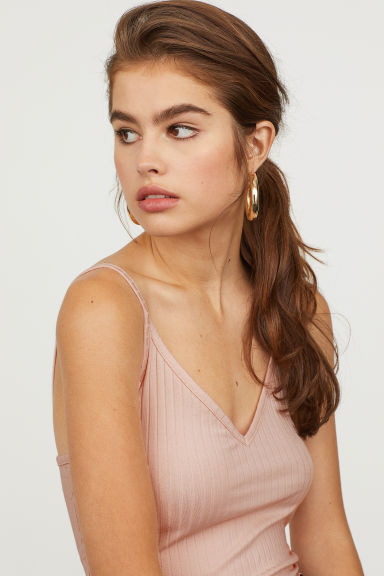

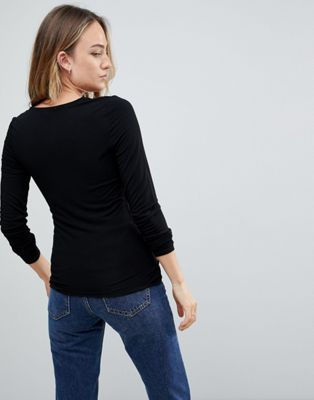

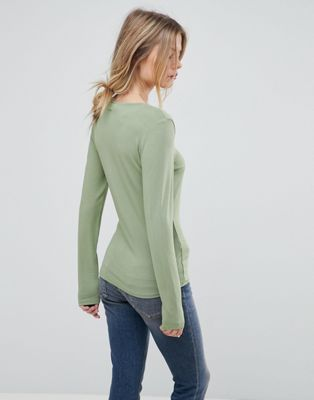

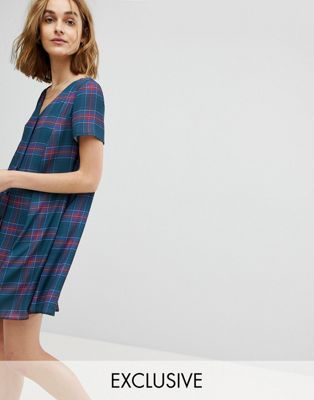

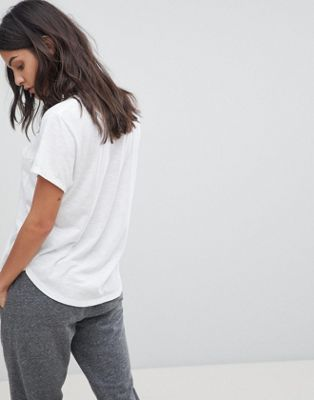

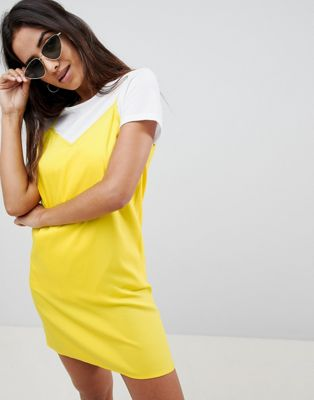

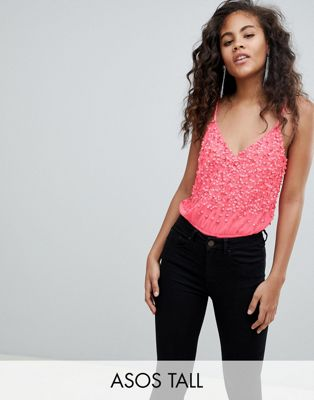

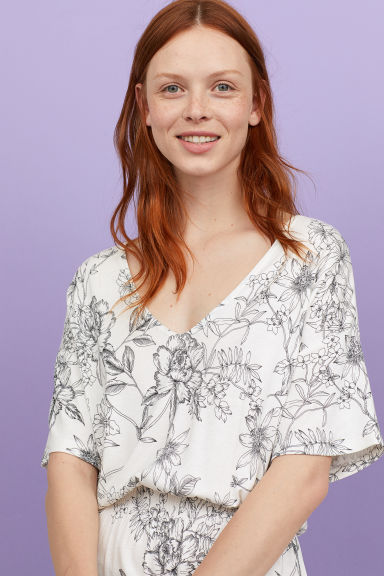

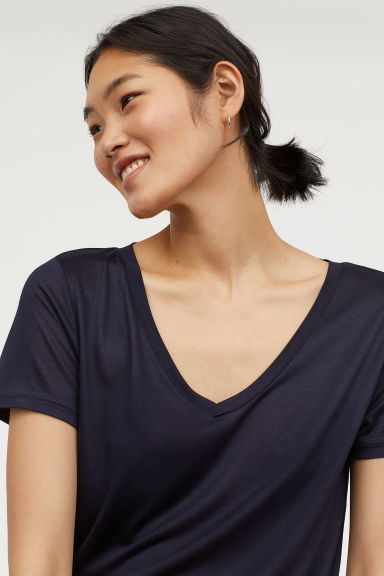

In [115]:
# dm = 1, dbow_words=0

load_img_d2v('models/doc2vec_dm1_word0_vec200_win3_min2_epoch100.model', '100', 20)    

[('104', 0.8012616038322449), ('246', 0.7907514572143555), ('31', 0.7750335931777954), ('165', 0.7597472667694092), ('363', 0.7514280080795288), ('125', 0.7504191398620605), ('309', 0.7445961236953735), ('20', 0.7143840789794922), ('32', 0.7107826471328735), ('317', 0.702681303024292), ('448', 0.7026429176330566), ('316', 0.7001550197601318), ('344', 0.6965476274490356), ('351', 0.6946157813072205), ('293', 0.6943001747131348), ('123', 0.6910964250564575), ('186', 0.6806600689888), ('542', 0.6777329444885254), ('109', 0.6772640943527222), ('70', 0.6770895719528198)]


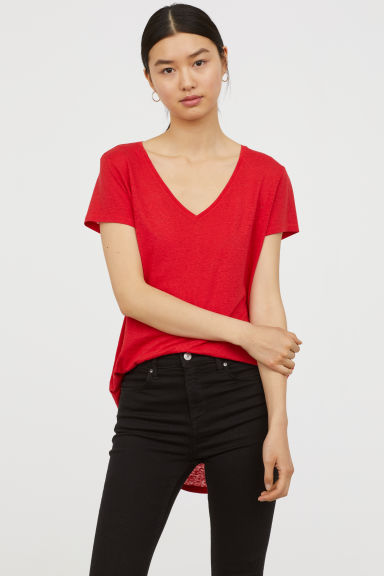

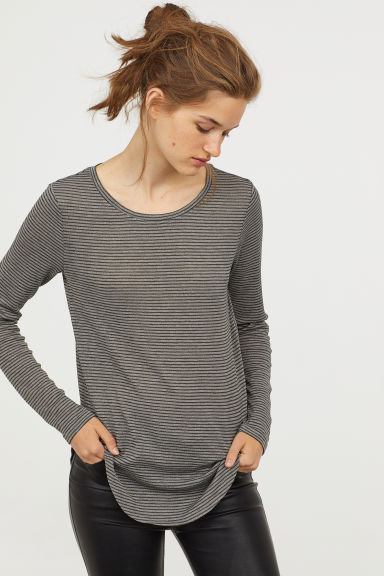

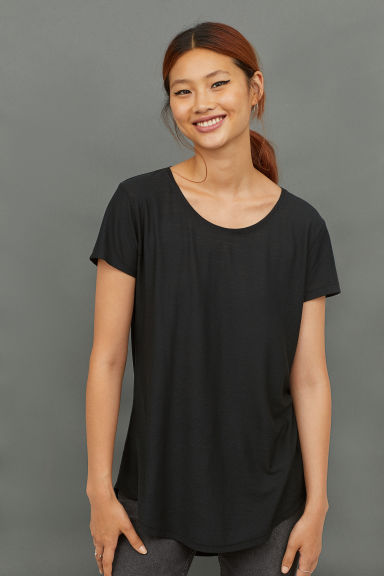

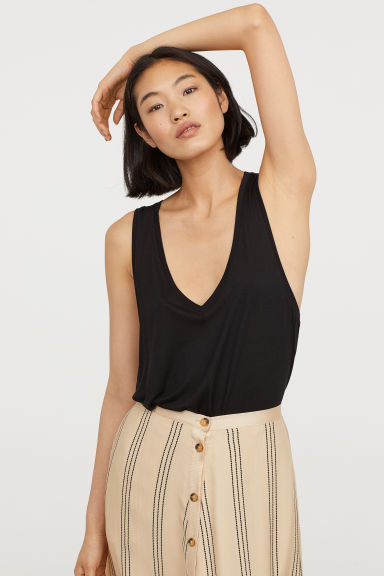

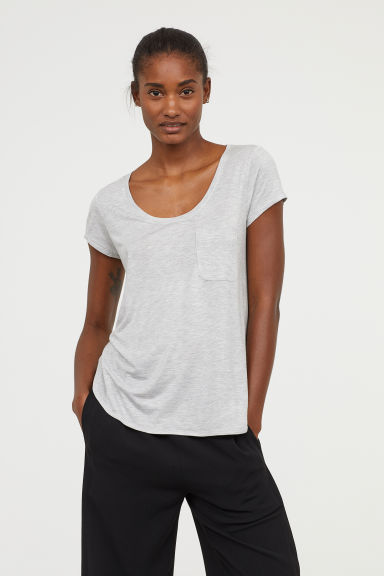

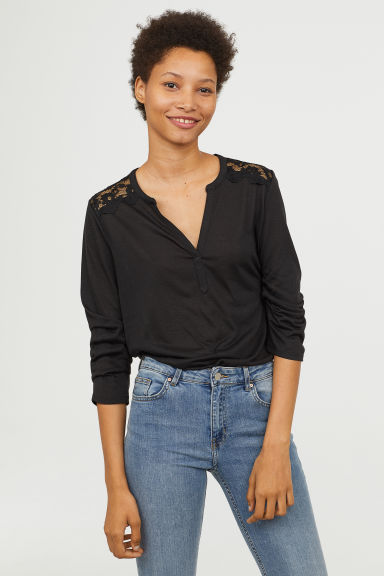

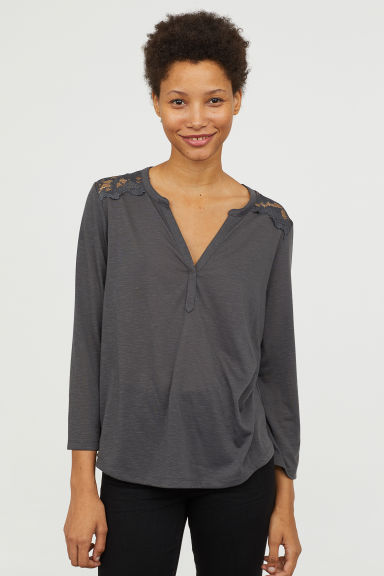

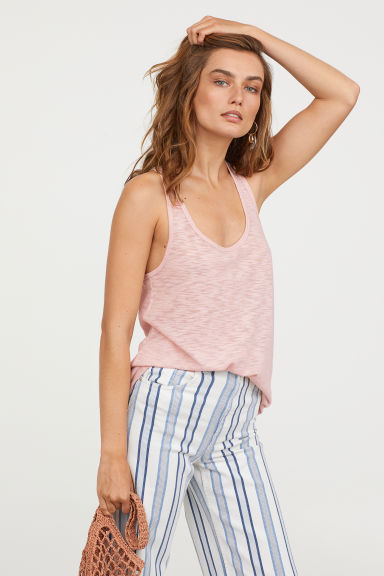

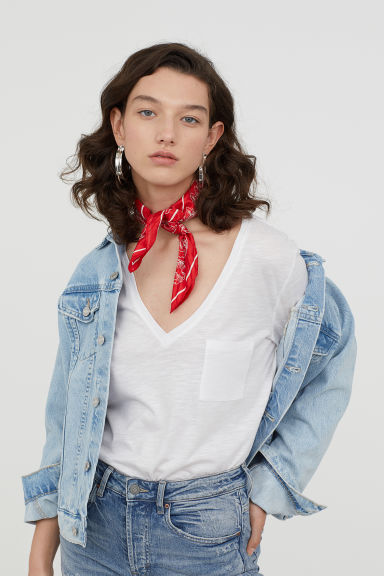

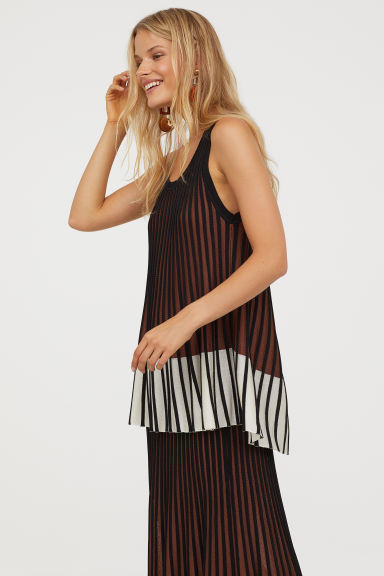

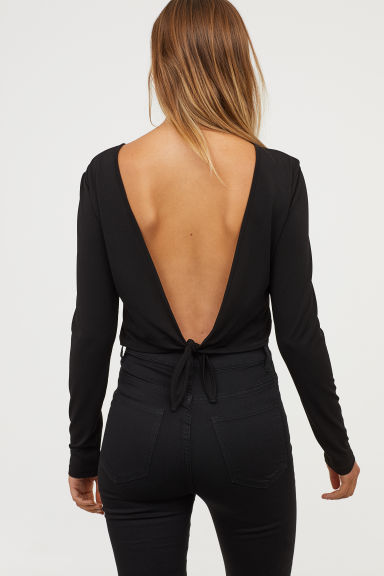

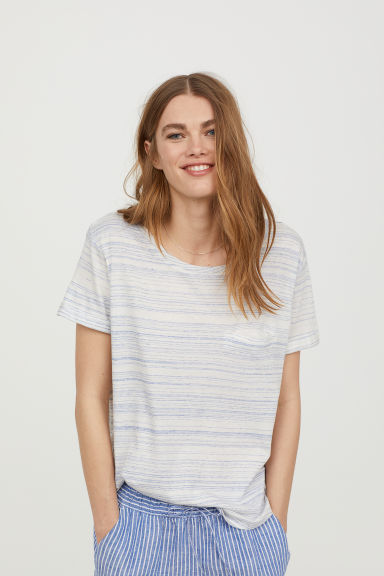

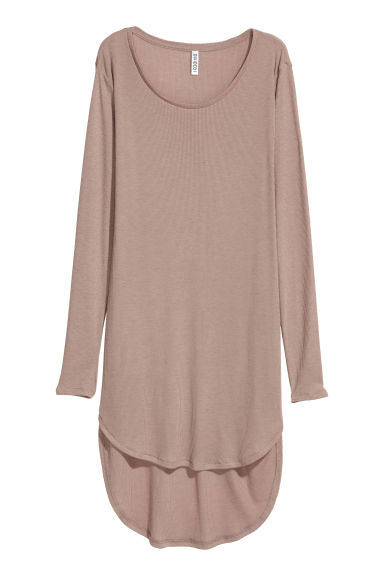

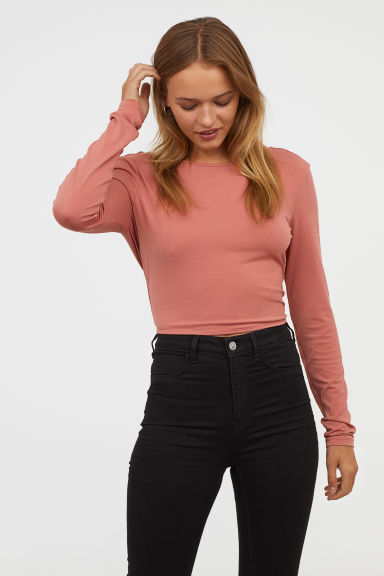

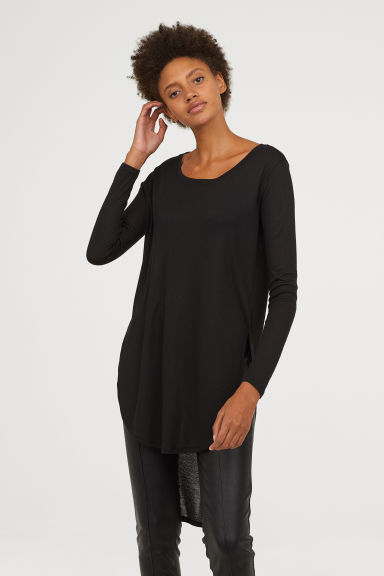

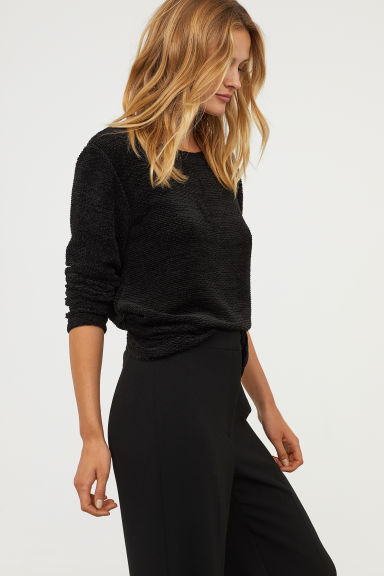

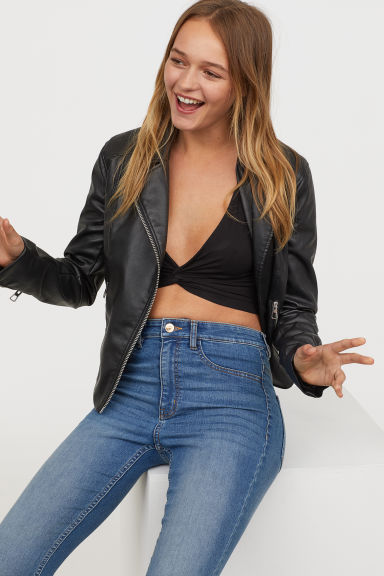

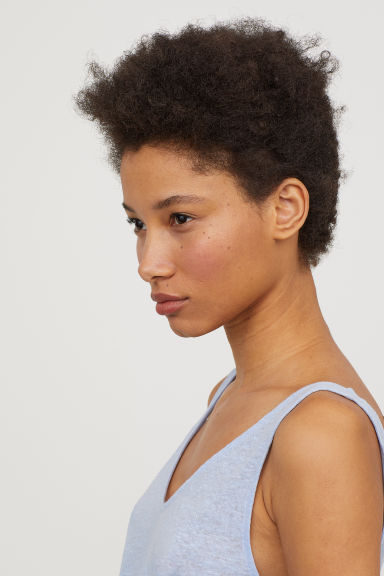

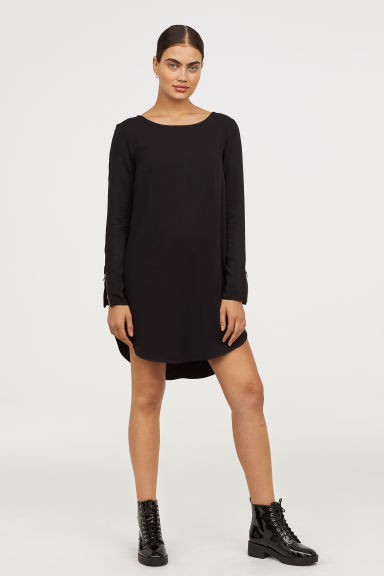

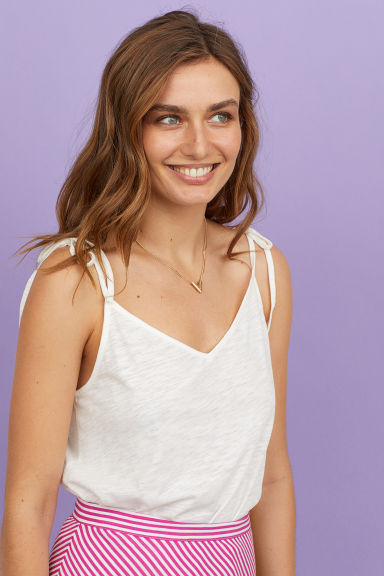

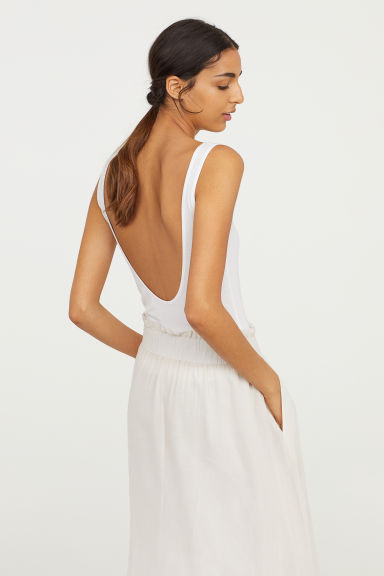

In [116]:
# dm = 0, dbow_words=1
load_img_d2v('models/doc2vec_dm0_word1_vec200_win3_min2_epoch100.model', '100', 20)    

[('104', 0.8276696801185608), ('246', 0.8111228942871094), ('165', 0.806812584400177), ('31', 0.8000622987747192), ('363', 0.7921836972236633), ('125', 0.7792573571205139), ('1', 0.774283766746521), ('70', 0.7698087692260742), ('309', 0.7690910696983337), ('344', 0.7679831981658936), ('256', 0.7638257741928101), ('317', 0.7632825970649719), ('30', 0.7542649507522583), ('22', 0.7512947916984558), ('20', 0.7431997656822205), ('37', 0.7367202043533325), ('351', 0.7358040809631348), ('186', 0.7355459928512573), ('316', 0.7351899147033691), ('958', 0.7340246438980103)]


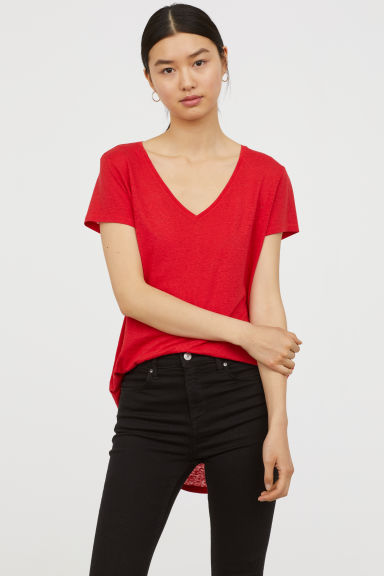

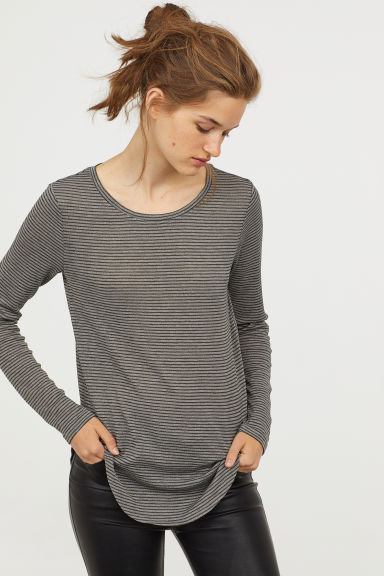

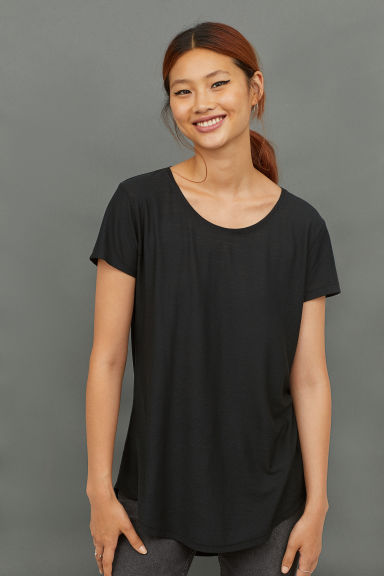

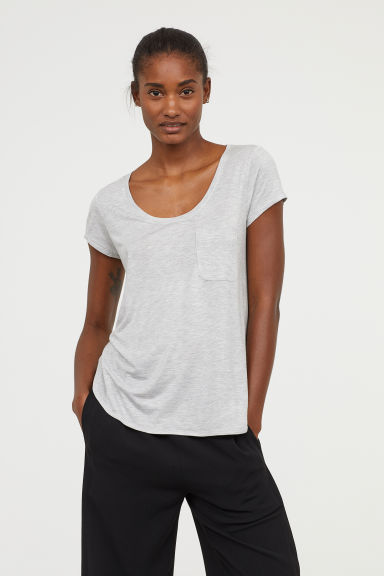

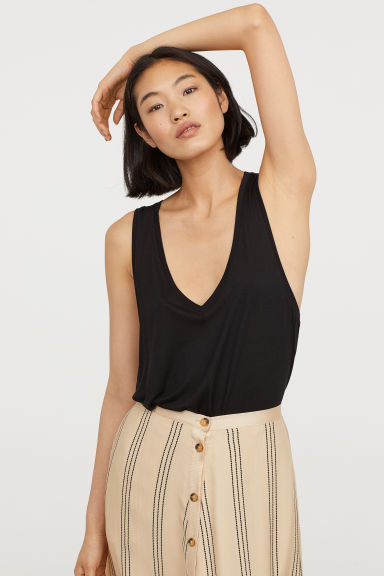

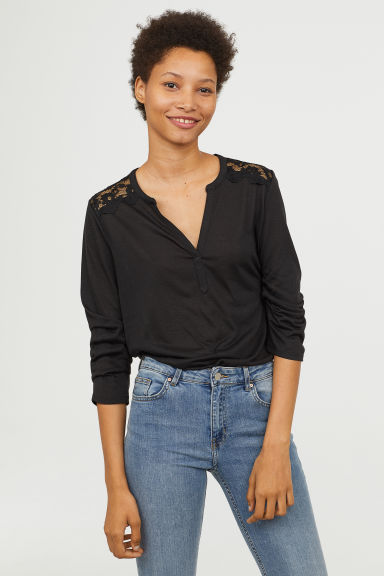

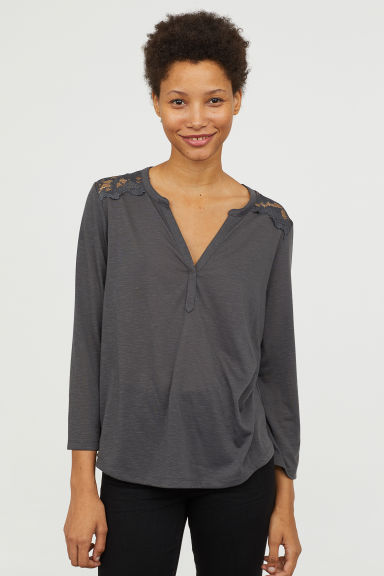

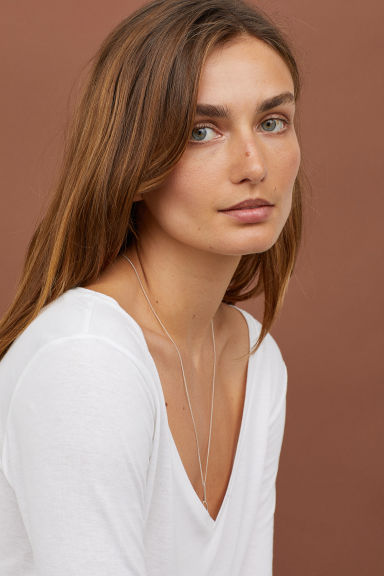

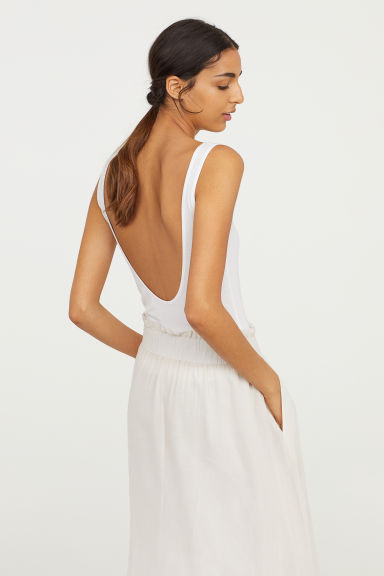

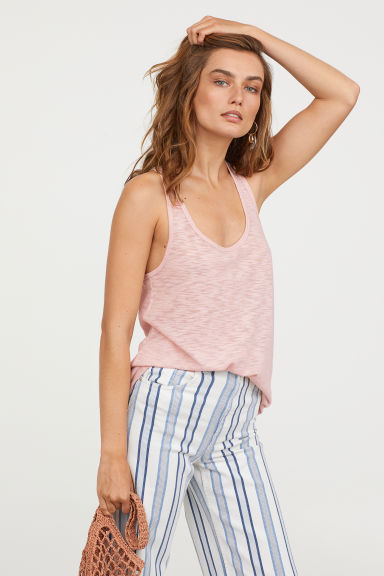

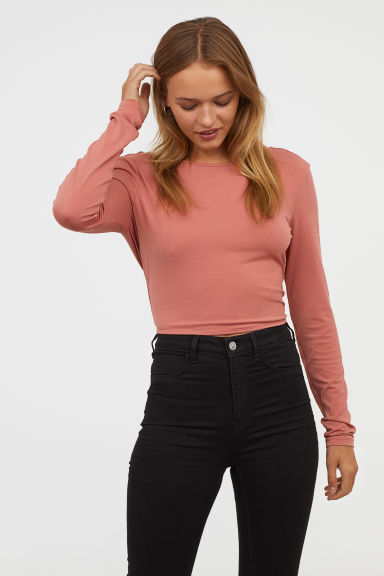

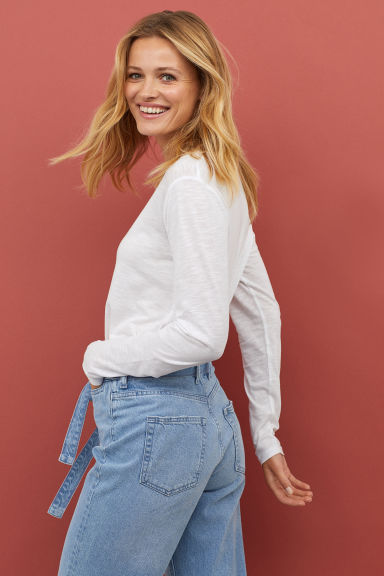

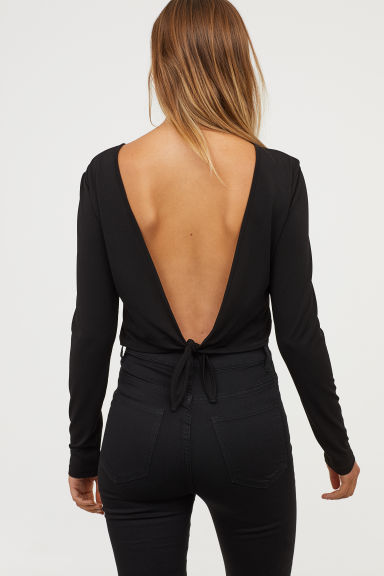

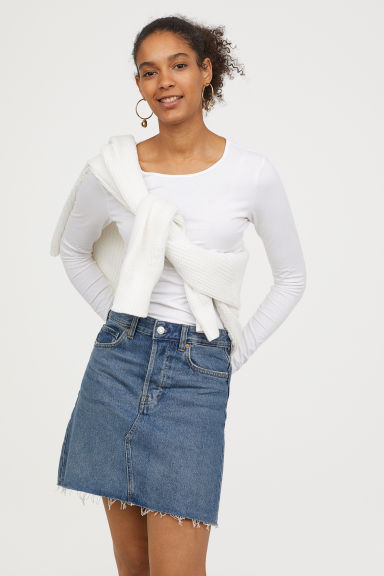

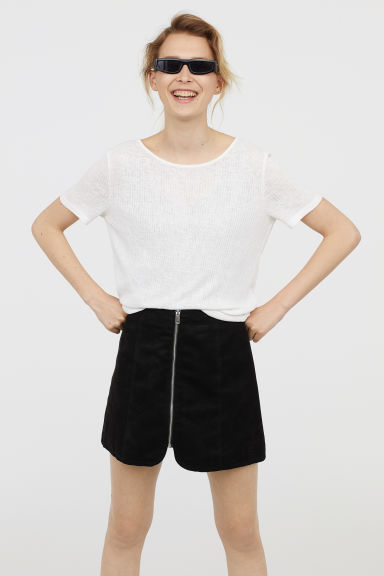

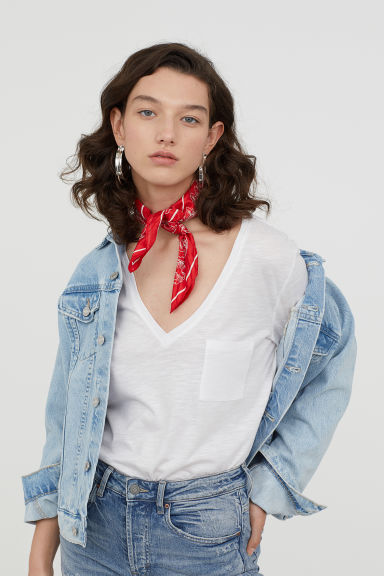

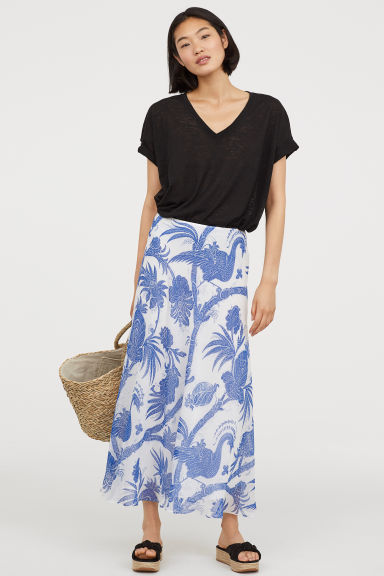

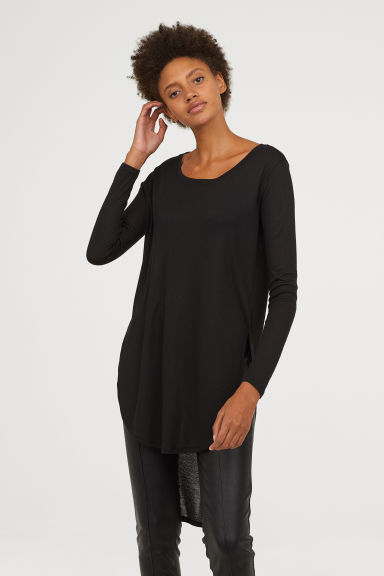

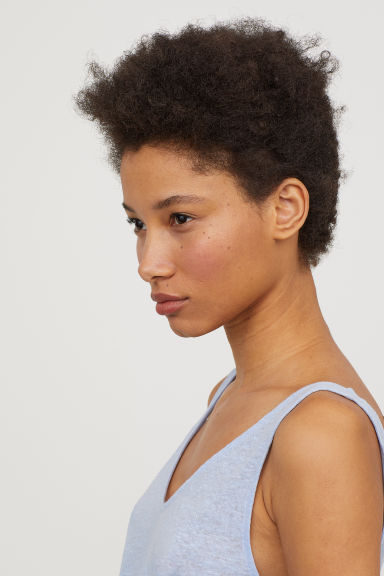

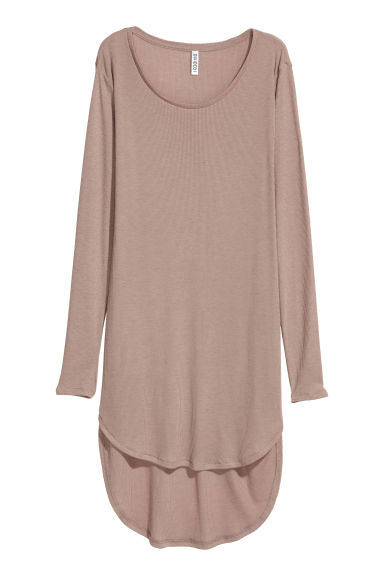

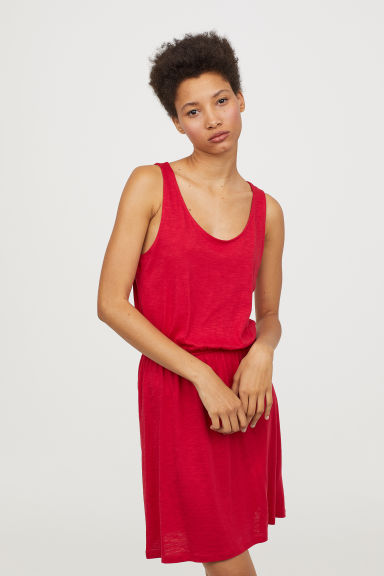

In [114]:
# dm = 0, dbow_words=0

load_img_d2v('models/doc2vec_dm0_word0_vec200_win3_min2_epoch100.model', '100', 20)    

## Instead, recommend products from those other clusters instead

In [341]:
df1 = df.drop(df.iloc[:,3:10], axis=1)
df1 = df1.drop('brand', axis=1)

category1 = ['polyester', 'cotton', 'spex', 'sleeves', 'jersey', 'woven', 'lining', 'lightweight', 'strech', 'vneck',\
'crew', 'button', 'softtouch', 'tshirt', 'classic', 'straps', 'floral', 'lace', 'sleeveless', 'zip', 'collar',\
 'loose', 'maxi', 'midi', 'mini', 'skirt', 'blouse', 'zipper', 'tank', 'baggy', 'neckline', 'ruffle']

for word in category1:
    df1.loc[df.alltext.str.contains(word), word] = 1
    df1[word] = df1[word].fillna('')

col_list = ['df1.' + word for word in category1]
#df1['tag'] = df1.website + df1.category + sum(col_list)

df.website 
df.category

col_list



['df1.polyester',
 'df1.cotton',
 'df1.spex',
 'df1.sleeves',
 'df1.jersey',
 'df1.woven',
 'df1.lining',
 'df1.lightweight',
 'df1.strech',
 'df1.vneck',
 'df1.crew',
 'df1.button',
 'df1.softtouch',
 'df1.tshirt',
 'df1.classic',
 'df1.straps',
 'df1.floral',
 'df1.lace',
 'df1.sleeveless',
 'df1.zip',
 'df1.collar',
 'df1.loose',
 'df1.maxi',
 'df1.midi',
 'df1.mini',
 'df1.skirt',
 'df1.blouse',
 'df1.zipper',
 'df1.tank',
 'df1.baggy',
 'df1.neckline',
 'df1.ruffle']

In [346]:
df1['ruffle'].plot.hist()

TypeError: Empty 'DataFrame': no numeric data to plot

In [343]:
df1

,alltext,category,website,id,polyester,cotton,spex,sleeves,jersey,woven,...,maxi,midi,mini,skirt,blouse,zipper,tank,baggy,neckline,ruffle
0,cotton tshirt tshirt in lightweight cotton jer...,Top,HM,0,,1,,,1,,...,,,,,,,,,,
1,vneck jersey top longsleeved top in airy vcose...,Top,HM,1,,,,,1,,...,,,,,,,,,,
2,jersey top with lace sleeveless top in soft vc...,Top,HM,2,,,,,1,,...,,,,,,,,,1,
3,vneck top conscious vneck top in airy jersey ...,Top,HM,3,1,,,1,1,,...,,,,,,,,,,
4,jersey camole top fit camole top in jersey wit...,Top,HM,4,,,,,1,,...,,,,,,,,,,
5,short tshirt short tshirt in soft jersey with ...,Top,HM,5,1,1,,1,1,,...,,,,,,,,,1,
6,long tshirt long tshirt in jersey with sewn cu...,Top,HM,6,,,,1,1,,...,,,,,,,,,,
7,tshirt fit tshirt in soft jersey fit,Top,HM,7,,,,,1,,...,,,,,,,,,,
8,tshirt tshirt in soft vcoseblend jersey cott...,Top,HM,8,,1,,,1,,...,,,,,,,,,,
9,vneck camole top vneck camole top in soft vcos...,Top,HM,9,1,,,,1,,...,,,,,,,,,,
